# **This notebook acts as the data preprocessor of eICU**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
import pyarrow.parquet as pq
import glob
import pyarrow as pa
import os 

## Loading our aggregated data

RIGHT NOW WE USE GENERATED HELPER FUNCTION TO LOAD THE DATA, BECAUSE THE ABOVE USUAL LINE JUST DID NOT WORK! I waited for 30 minutes with kernel keep crashing everything!

In [3]:
def load_parquet_chunks_to_dataframe(file_pattern="parquets/client_2_part_*.parquet"):
    """
    Loads and concatenates parquet chunk files into a single pandas DataFrame.
    Args: file_pattern (str): The glob pattern to find the Parquet chunk files.
    Returns: pandas.DataFrame or None: The concatenated DataFrame if successful, otherwise None.
    """
    # Get a list of all your Parquet chunk files, sorted to maintain order
    parquet_files = sorted(glob.glob(file_pattern))

    if not parquet_files:
        print(f"No Parquet chunk files found matching pattern: '{file_pattern}'.")
        print("Please ensure the chunking process completed successfully and the files are in the correct directory.")
        return None
    else:
        print(f"Found {len(parquet_files)} Parquet files: {parquet_files}")

    # List to hold DataFrames from each chunk
    list_of_dataframes = []
    total_rows = 0

    # Read each Parquet chunk into a DataFrame
    for i, f_path in enumerate(parquet_files):
        try:
            if not os.path.exists(f_path):
                print(f"File not found: {f_path}. Skipping.")
                continue

            print(f"Reading chunk {i+1}/{len(parquet_files)}: {f_path}...")
            
            df_chunk = pd.read_parquet(f_path)
            list_of_dataframes.append(df_chunk)
            total_rows += len(df_chunk)

            print(f"Successfully read chunk {i+1}. Shape: {df_chunk.shape}. Rows so far: {total_rows}")

        except Exception as e:
            print(f"Error reading chunk {f_path}: {e}")
            # If one chunk fails, it's often better to stop and investigate
            # rather than concatenating partial data.
            print("Aborting concatenation due to error in reading a chunk.")
            return None

    if list_of_dataframes:
        # Concatenate all DataFrames in the list
        print("\nConcatenating all loaded chunks...")
        try:
            # Using ignore_index=True will create a new default integer index
            # for the combined DataFrame.
            combined_df = pd.concat(list_of_dataframes, ignore_index=True)
            print("Successfully concatenated all chunks.")
            print(f"Final DataFrame shape: {combined_df.shape}")
            print(f"Total rows in combined DataFrame: {len(combined_df)}")

            # Basic validation: check if total rows match
            if len(combined_df) == total_rows:
                print("Row count matches the sum of rows from individual chunks.")
            else:
                print(f"WARNING: Row count mismatch! Combined: {len(combined_df)}, Sum of chunks: {total_rows}")

            return combined_df
        except Exception as e:
            print(f"Error concatenating DataFrames: {e}")
            return None
    else:
        print("No DataFrames were read successfully, cannot concatenate.")
        return None

# How to use the function:
if __name__ == "__main__":
    # This pattern assumes your files are named like 'client_2_part_0.parquet', 'client_2_part_1.parquet', etc.
    # Adjust the pattern if your filenames are different.
    client_2_dataframe = load_parquet_chunks_to_dataframe(file_pattern="client_2_part_*.parquet")

    if client_2_dataframe is not None:
        print("\nSuccessfully loaded the dataset into 'client_2_dataframe'.")
        print("First 5 rows of the combined dataset:")
        print(client_2_dataframe.head())
        print("\nDataset info:")
        client_2_dataframe.info(memory_usage='deep')
    else:
        print("\nFailed to load the dataset.")

Found 11 Parquet files: ['client_2_part_0.parquet', 'client_2_part_1.parquet', 'client_2_part_10.parquet', 'client_2_part_2.parquet', 'client_2_part_3.parquet', 'client_2_part_4.parquet', 'client_2_part_5.parquet', 'client_2_part_6.parquet', 'client_2_part_7.parquet', 'client_2_part_8.parquet', 'client_2_part_9.parquet']
Reading chunk 1/11: client_2_part_0.parquet...
Successfully read chunk 1. Shape: (20000, 6231). Rows so far: 20000
Reading chunk 2/11: client_2_part_1.parquet...
Successfully read chunk 2. Shape: (20000, 6231). Rows so far: 40000
Reading chunk 3/11: client_2_part_10.parquet...
Successfully read chunk 3. Shape: (859, 6231). Rows so far: 40859
Reading chunk 4/11: client_2_part_2.parquet...
Successfully read chunk 4. Shape: (20000, 6231). Rows so far: 60859
Reading chunk 5/11: client_2_part_3.parquet...
Successfully read chunk 5. Shape: (20000, 6231). Rows so far: 80859
Reading chunk 6/11: client_2_part_4.parquet...
Successfully read chunk 6. Shape: (20000, 6231). Rows so

# **Skip the above cell and just run this, if the computer allows it:**

In [ ]:
client_2 = pd.read_csv('client_2_raw_hour.csv', low_memory=False)

In [4]:
client_2 = client_2_dataframe

In [5]:
client_2

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,carePlanGeneral_cplitemvalue_mode_h14,carePlanGeneral_cplitemvalue_mode_h15,carePlanGeneral_cplitemvalue_mode_h16,carePlanGeneral_cplitemvalue_mode_h17,carePlanGeneral_cplitemvalue_mode_h18,carePlanGeneral_cplitemvalue_mode_h19,carePlanGeneral_cplitemvalue_mode_h20,carePlanGeneral_cplitemvalue_mode_h21,carePlanGeneral_cplitemvalue_mode_h22,carePlanGeneral_cplitemvalue_mode_h23
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,...,None,None,None,None,None,None,None,None,None,None
1,141178,128927,Female,52,Caucasian,60,83,None,162.6,08:56:00,...,None,None,None,None,None,None,None,None,None,None
2,141179,128927,Female,52,Caucasian,60,83,None,162.6,08:56:00,...,None,None,None,None,None,None,None,None,None,None
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,...,None,None,None,None,None,None,None,None,None,Combined device and drug therapy
4,141196,128943,Male,71,Caucasian,67,109,None,162.6,20:21:00,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200854,3348097,2738486,Female,39,African American,458,1105,"Hematoma, subdural",170.0,15:28:00,...,None,None,None,None,None,HOB 30 degrees,None,None,None,None
200855,3348104,2738493,Male,70,Caucasian,458,1105,"Hemorrhage/hematoma, intracranial",172.7,05:15:00,...,None,None,None,None,None,None,None,None,None,None
200856,3348105,2738494,Female,86,Caucasian,458,1104,Rhythm disturbance (conduction defect),165.1,04:30:00,...,None,None,None,HOB 30 degrees,None,None,None,None,None,None
200857,3348111,2738499,Male,80,Caucasian,458,1109,"Hypertension, uncontrolled (for cerebrovascula...",188.0,00:23:00,...,None,None,Intermediate,None,None,None,None,HOB 30 degrees,None,None


## Understadig the structure of the dataset

## Checking the number of missing values

In [6]:
missing_chunk = client_2.copy()

# Calculate missing value stats
missing_stats = (
    missing_chunk.isnull().sum()
    .to_frame(name='Missing_Count')
    .assign(Total=missing_chunk.shape[0])
    .assign(Missing_Percent=lambda x: (x['Missing_Count'] / x['Total']) * 100)
    .sort_values(by='Missing_Percent', ascending=False)
)

# Filter only columns with missing values
missing_stats_filtered = missing_stats[missing_stats['Missing_Count'] > 0]

missing_stats_filtered.shape[0] # Number of columns with missing values

6213

In [7]:
# Display top 20 columns with the highest percentage of missing values
top_missing = missing_stats_filtered.head(20).copy()
top_missing.reset_index(inplace=True)
top_missing.rename(columns={'index': 'Column Name'}, inplace=True)

top_missing

,Column Name,Missing_Count,Total,Missing_Percent
0,customLab_labotherresult_std_h17,200858,200859,99.999502
1,customLab_customlabid_std_h4,200858,200859,99.999502
2,customLab_labotherresult_std_h13,200858,200859,99.999502
3,customLab_labotherresult_std_h10,200858,200859,99.999502
4,customLab_customlabid_std_h15,200858,200859,99.999502
5,customLab_customlabid_std_h18,200858,200859,99.999502
6,customLab_labotherresult_std_h5,200858,200859,99.999502
7,customLab_customlabid_std_h21,200858,200859,99.999502
8,customLab_labotherresult_std_h4,200858,200859,99.999502
9,customLab_customlabid_min_h23,200858,200859,99.999502


In [8]:
missing_percent = client_2.isnull().mean().sort_values(ascending=False) * 100
missing_percent

customLab_labotherresult_std_h17    99.999502
customLab_customlabid_std_h4        99.999502
customLab_labotherresult_std_h13    99.999502
customLab_labotherresult_std_h10    99.999502
customLab_customlabid_std_h15       99.999502
                                      ...    
uniquepid                            0.000000
unitadmittime                        0.000000
unitdischtime                        0.000000
patienthealthsystemstayid            0.000000
patientunitstayid                    0.000000
Length: 6231, dtype: float64

We drop columns with more than $95%$ of missing values.

In [9]:
# Define a threshold for dropping columns based on missing percentage
drop_threshold = 95 # percent
columns_to_drop = missing_stats_filtered[missing_stats_filtered['Missing_Percent'] > drop_threshold].index.tolist()

# Separate remaining columns for potential imputation (not to be dropped)
columns_to_impute = missing_stats_filtered[
    (missing_stats_filtered['Missing_Percent'] <= drop_threshold)
].index.tolist()

# Show the first few columns that would be dropped and imputed
drop_and_impute_summary = {
    "Columns to drop (sample)": columns_to_drop[:10],
    "Drop count": len(columns_to_drop),
    "Columns to impute (sample)": columns_to_impute[:10],
    "Impute count": len(columns_to_impute)
}

drop_and_impute_summary

{'Columns to drop (sample)': ['customLab_labotherresult_std_h17',
  'customLab_customlabid_std_h4',
  'customLab_labotherresult_std_h13',
  'customLab_labotherresult_std_h10',
  'customLab_customlabid_std_h15',
  'customLab_customlabid_std_h18',
  'customLab_labotherresult_std_h5',
  'customLab_customlabid_std_h21',
  'customLab_labotherresult_std_h4',
  'customLab_customlabid_min_h23'],
 'Drop count': 2419,
 'Columns to impute (sample)': ['medication_gtc_std_h11',
  'medication_drugstartoffset_std_h11',
  'medication_medicationid_std_h11',
  'medication_drugorderoffset_std_h11',
  'medication_drugstopoffset_std_h11',
  'medication_gtc_std_h13',
  'medication_drugorderoffset_std_h13',
  'medication_drugstopoffset_std_h13',
  'medication_medicationid_std_h13',
  'medication_drugstartoffset_std_h13'],
 'Impute count': 3794}

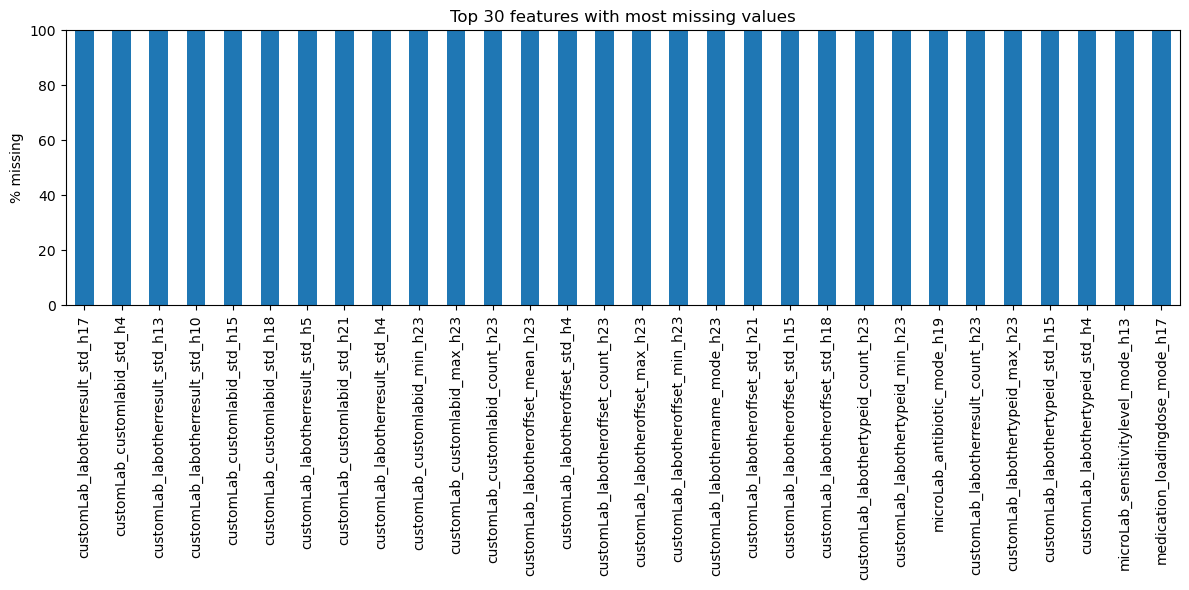

In [10]:
missing_percent.head(30).plot(kind='bar', figsize=(12, 6), title="Top 30 features with most missing values")
plt.ylabel('% missing')
plt.tight_layout()
plt.ylim(0,100)
plt.show()

Now drop the top missing columns.

In [11]:
client_2.drop(columns=columns_to_drop, inplace=True)

In [12]:
client_2

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,carePlanGeneral_cplitemvalue_mode_h3,carePlanGeneral_cplitemvalue_mode_h4,carePlanGeneral_cplitemvalue_mode_h5,carePlanGeneral_cplitemvalue_mode_h6,carePlanGeneral_cplitemvalue_mode_h7,carePlanGeneral_cplitemvalue_mode_h8,carePlanGeneral_cplitemvalue_mode_h9,carePlanGeneral_cplitemvalue_mode_h10,carePlanGeneral_cplitemvalue_mode_h11,carePlanGeneral_cplitemvalue_mode_h12
0,141168,128919,Female,70,Caucasian,59,91,"Rhythm disturbance (atrial, supraventricular)",152.4,15:54:00,...,None,None,None,None,None,None,None,None,None,None
1,141178,128927,Female,52,Caucasian,60,83,None,162.6,08:56:00,...,None,None,None,None,None,None,None,None,None,None
2,141179,128927,Female,52,Caucasian,60,83,None,162.6,08:56:00,...,None,None,None,None,None,None,None,None,None,None
3,141194,128941,Male,68,Caucasian,73,92,"Sepsis, renal/UTI (including bladder)",180.3,18:18:40,...,None,None,None,Drug therapy,None,None,None,None,Not indicated,None
4,141196,128943,Male,71,Caucasian,67,109,None,162.6,20:21:00,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200854,3348097,2738486,Female,39,African American,458,1105,"Hematoma, subdural",170.0,15:28:00,...,None,None,None,None,None,None,Continuous infusion - with daily holiday,None,None,Intermediate
200855,3348104,2738493,Male,70,Caucasian,458,1105,"Hemorrhage/hematoma, intracranial",172.7,05:15:00,...,None,None,None,None,None,None,None,None,None,Parenteral - bolus prn
200856,3348105,2738494,Female,86,Caucasian,458,1104,Rhythm disturbance (conduction defect),165.1,04:30:00,...,None,None,None,Continuous infusion - with daily holiday,None,None,None,None,None,HOB 30 degrees
200857,3348111,2738499,Male,80,Caucasian,458,1109,"Hypertension, uncontrolled (for cerebrovascula...",188.0,00:23:00,...,None,None,None,None,None,None,HOB 30 degrees,None,High,None


### Like in MIMIC Extract handle cohorts

In [13]:
print(client_2.columns.tolist())

['patientunitstayid', 'patienthealthsystemstayid', 'gender', 'age', 'ethnicity', 'hospitalid', 'wardid', 'apacheadmissiondx', 'admissionheight', 'hospitaladmittime24', 'hospitaladmitoffset', 'hospitaladmitsource', 'hospitaldischargeyear', 'hospitaldischargetime24', 'hospitaldischargeoffset', 'hospitaldischargelocation', 'hospitaldischargestatus', 'unittype', 'unitadmittime24', 'unitadmitsource', 'unitvisitnumber', 'unitstaytype', 'admissionweight', 'dischargeweight', 'unitdischargetime24', 'unitdischargeoffset', 'unitdischargelocation', 'unitdischargestatus', 'uniquepid', 'unitadmittime', 'unitdischtime', 'admissionDx_admissiondxid_mean_h0', 'admissionDx_admissiondxid_mean_h1', 'admissionDx_admissiondxid_mean_h2', 'admissionDx_admissiondxid_std_h0', 'admissionDx_admissiondxid_std_h1', 'admissionDx_admissiondxid_std_h2', 'admissionDx_admissiondxid_min_h0', 'admissionDx_admissiondxid_min_h1', 'admissionDx_admissiondxid_min_h2', 'admissionDx_admissiondxid_max_h0', 'admissionDx_admissiondx

In [14]:
# To numeric:
client_2['age'] = client_2['age'].apply(pd.to_numeric, errors='coerce')

# AGAIN only keep adults, but since eICU has age, we can skip some steps and directly just do this:
adults = client_2[client_2['age'] >= 15].copy()

In [15]:
adults['unitadmittime'] = pd.to_datetime(adults['unitadmittime'], errors='coerce')
adults['unitdischtime'] = pd.to_datetime(adults['unitdischtime'], errors='coerce')

# The 12 hours to 10 days stay filter:
first = (
    adults
    .sort_values(['patienthealthsystemstayid','unitadmittime'])
    .drop_duplicates(subset='patienthealthsystemstayid', keep='first')
    .copy()
)

first['los_hours'] = (
    first['unitdischtime'] - first['unitadmittime']
).dt.total_seconds() / 3600

cohort2 = first[
    (first['los_hours'] >= 12) &
    (first['los_hours'] < 240)
].copy()

In [16]:
# Generated code for summary check just to be sure:
print("All stays:", first.shape[0])
print("Filtered cohort:", cohort2.shape[0])
print(cohort2['los_hours'].describe())

All stays: 160056
Filtered cohort: 42672
count    42672.000000
mean        16.726952
std          2.840540
min         12.000000
25%         14.366667
50%         16.516667
75%         18.866667
max         23.933333
Name: los_hours, dtype: float64


## Handling categorical variables

Specifically mortality first

In [17]:
cohort2['gender'].value_counts()

gender
Male       22836
Female     19826
Unknown        2
Other          1
Name: count, dtype: int64

In [18]:
cohort2_test = cohort2.copy()

cohort2_test['gender'] = (cohort2_test['gender'].map({'Male': 0, 'Female': 1}))

In [19]:
cohort2_test['gender'].unique()

array([ 1.,  0., nan])

In [20]:
# Locate the discharge-status column

status_cols = [c for c in cohort2_test.columns if 'dischargestatus' in c.lower()]

if not status_cols:
    raise KeyError("No discharge-status column found!")

status_col = status_cols[0]

print("Found status col:", status_col)
print(cohort2[status_col].value_counts())

Found status col: hospitaldischargestatus
hospitaldischargestatus
Alive      39621
Expired     2667
Name: count, dtype: int64


In [21]:
status_col = 'hospitaldischargestatus'
cohort2_test[status_col].str.lower().unique()

array(['alive', 'expired', None], dtype=object)

In [22]:
status = cohort2_test[status_col].fillna('expired').str.title()

cohort2_test['is_alive'] = (status.map({'Alive': 1, 'Expired': 0}).astype(int))

cohort2_test['is_alive'].value_counts()

is_alive
1    39621
0     3051
Name: count, dtype: int64

In [23]:
cohort2_test.columns.tolist()

['patientunitstayid',
 'patienthealthsystemstayid',
 'gender',
 'age',
 'ethnicity',
 'hospitalid',
 'wardid',
 'apacheadmissiondx',
 'admissionheight',
 'hospitaladmittime24',
 'hospitaladmitoffset',
 'hospitaladmitsource',
 'hospitaldischargeyear',
 'hospitaldischargetime24',
 'hospitaldischargeoffset',
 'hospitaldischargelocation',
 'hospitaldischargestatus',
 'unittype',
 'unitadmittime24',
 'unitadmitsource',
 'unitvisitnumber',
 'unitstaytype',
 'admissionweight',
 'dischargeweight',
 'unitdischargetime24',
 'unitdischargeoffset',
 'unitdischargelocation',
 'unitdischargestatus',
 'uniquepid',
 'unitadmittime',
 'unitdischtime',
 'admissionDx_admissiondxid_mean_h0',
 'admissionDx_admissiondxid_mean_h1',
 'admissionDx_admissiondxid_mean_h2',
 'admissionDx_admissiondxid_std_h0',
 'admissionDx_admissiondxid_std_h1',
 'admissionDx_admissiondxid_std_h2',
 'admissionDx_admissiondxid_min_h0',
 'admissionDx_admissiondxid_min_h1',
 'admissionDx_admissiondxid_min_h2',
 'admissionDx_admissi

In [24]:
cohort2_test['los_hours']

7        12.000000
11       15.916667
12       17.883333
20       21.383333
23       14.650000
           ...    
40836    19.533333
40845    20.516667
40854    17.816667
40855    21.150000
40858    15.466667
Name: los_hours, Length: 42672, dtype: float64

In [25]:
cohort2_test

,patientunitstayid,patienthealthsystemstayid,gender,age,ethnicity,hospitalid,wardid,apacheadmissiondx,admissionheight,hospitaladmittime24,...,carePlanGeneral_cplitemvalue_mode_h5,carePlanGeneral_cplitemvalue_mode_h6,carePlanGeneral_cplitemvalue_mode_h7,carePlanGeneral_cplitemvalue_mode_h8,carePlanGeneral_cplitemvalue_mode_h9,carePlanGeneral_cplitemvalue_mode_h10,carePlanGeneral_cplitemvalue_mode_h11,carePlanGeneral_cplitemvalue_mode_h12,los_hours,is_alive
7,141208,128952,1.0,25.0,Caucasian,73,93,"Overdose, sedatives, hypnotics, antipsychotics...",172.7,11:23:00,...,None,None,None,None,None,None,None,None,12.000000,1
11,141244,128982,0.0,59.0,Caucasian,73,92,"Graft, femoral-popliteal bypass",180.3,01:36:00,...,None,Not indicated - Patient ambulating,None,None,None,None,None,Intermediate,15.916667,1
12,141260,128995,1.0,43.0,African American,73,99,Asthma,172.7,01:57:00,...,None,None,None,None,None,None,None,None,17.883333,1
20,141289,129020,1.0,61.0,Caucasian,67,109,Pneumothorax,162.6,17:32:00,...,None,None,None,Intubated/oral ETT,None,None,None,None,21.383333,1
23,141304,129031,0.0,70.0,Caucasian,59,91,"Sepsis, pulmonary",165.0,08:54:00,...,None,None,None,None,None,None,None,None,14.650000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40836,3353127,2742991,0.0,59.0,Caucasian,458,1104,"Hypertension-pulmonary, primary/idiopathic",165.1,02:17:00,...,None,None,None,None,None,None,None,None,19.533333,1
40845,3353196,2743055,1.0,66.0,Caucasian,458,1104,Atelectasis,157.5,06:38:00,...,Intermediate,None,None,None,None,None,None,HOB 30 degrees,20.516667,1
40854,3353235,2743084,0.0,50.0,Caucasian,458,1109,"CHF, congestive heart failure",175.3,04:55:00,...,None,None,None,None,None,None,None,None,17.816667,1
40855,3353237,2743086,1.0,79.0,Caucasian,458,1106,"Embolus, pulmonary",162.6,01:45:00,...,None,None,None,None,None,None,Bathroom privileges,None,21.150000,1


In [26]:
# Now define exactly your static columns
# static_cols = ['subject_id','icustay_id','age','gender','los_hours','is_alive']
static_cols = ['patientunitstayid', 'age', 'gender', 'los_hours', 'is_alive', 'admissionheight', 'admissionweight', 'dischargeweight', ]
static = cohort2_test[static_cols].copy()
static

,patientunitstayid,age,gender,los_hours,is_alive,admissionheight,admissionweight,dischargeweight
7,141208,25.0,1.0,12.000000,1,172.7,95.3,95.3
11,141244,59.0,0.0,15.916667,1,180.3,92.3,94.4
12,141260,43.0,1.0,17.883333,1,172.7,69.9,70.3
20,141289,61.0,1.0,21.383333,1,162.6,NaN,NaN
23,141304,70.0,0.0,14.650000,1,165.0,NaN,68.0
...,...,...,...,...,...,...,...,...
40836,3353127,59.0,0.0,19.533333,1,165.1,97.8,107.1
40845,3353196,66.0,1.0,20.516667,1,157.5,71.5,93.7
40854,3353235,50.0,0.0,17.816667,1,175.3,90.0,99.2
40855,3353237,79.0,1.0,21.150000,1,162.6,78.4,81.4


### Handling date time variables

In [27]:
# From old preprocessing code:
static['admit_hour'] = cohort2['unitadmittime'].dt.hour

In [28]:
# Cyclical (sin/cos) encodings so your model “knows” that 23 to 0h is adjacent:

# hour: 0 to 23 circle
static['hour_sin'] = np.sin(2*np.pi * static['admit_hour']   / 24)
static['hour_cos'] = np.cos(2*np.pi * static['admit_hour']   / 24)

In [29]:
static

,patientunitstayid,age,gender,los_hours,is_alive,admissionheight,admissionweight,dischargeweight,admit_hour,hour_sin,hour_cos
7,141208,25.0,1.0,12.000000,1,172.7,95.3,95.3,11,0.258819,-0.965926
11,141244,59.0,0.0,15.916667,1,180.3,92.3,94.4,2,0.500000,0.866025
12,141260,43.0,1.0,17.883333,1,172.7,69.9,70.3,2,0.500000,0.866025
20,141289,61.0,1.0,21.383333,1,162.6,NaN,NaN,0,0.000000,1.000000
23,141304,70.0,0.0,14.650000,1,165.0,NaN,68.0,8,0.866025,-0.500000
...,...,...,...,...,...,...,...,...,...,...,...
40836,3353127,59.0,0.0,19.533333,1,165.1,97.8,107.1,0,0.000000,1.000000
40845,3353196,66.0,1.0,20.516667,1,157.5,71.5,93.7,2,0.500000,0.866025
40854,3353235,50.0,0.0,17.816667,1,175.3,90.0,99.2,5,0.965926,0.258819
40855,3353237,79.0,1.0,21.150000,1,162.6,78.4,81.4,1,0.258819,0.965926


In [30]:
static.dtypes

patientunitstayid      Int32
age                  float64
gender               float64
los_hours            float64
is_alive               int64
admissionheight      float64
admissionweight      float64
dischargeweight      float64
admit_hour             int32
hour_sin             float64
hour_cos             float64
dtype: object

### Putting it all together

In [31]:
dyn_cols = sorted(set(cohort2_test.columns) - set(static_cols))
X_dyn = cohort2_test[dyn_cols].copy()

In [32]:
print(dyn_cols)

['admissionDx_admissiondxid_count_h0', 'admissionDx_admissiondxid_count_h1', 'admissionDx_admissiondxid_count_h2', 'admissionDx_admissiondxid_max_h0', 'admissionDx_admissiondxid_max_h1', 'admissionDx_admissiondxid_max_h2', 'admissionDx_admissiondxid_mean_h0', 'admissionDx_admissiondxid_mean_h1', 'admissionDx_admissiondxid_mean_h2', 'admissionDx_admissiondxid_min_h0', 'admissionDx_admissiondxid_min_h1', 'admissionDx_admissiondxid_min_h2', 'admissionDx_admissiondxid_std_h0', 'admissionDx_admissiondxid_std_h1', 'admissionDx_admissiondxid_std_h2', 'admissionDx_admitdxenteredoffset_count_h0', 'admissionDx_admitdxenteredoffset_count_h1', 'admissionDx_admitdxenteredoffset_count_h2', 'admissionDx_admitdxenteredoffset_max_h0', 'admissionDx_admitdxenteredoffset_max_h1', 'admissionDx_admitdxenteredoffset_max_h2', 'admissionDx_admitdxenteredoffset_mean_h0', 'admissionDx_admitdxenteredoffset_mean_h1', 'admissionDx_admitdxenteredoffset_mean_h2', 'admissionDx_admitdxenteredoffset_min_h0', 'admissionD

In [33]:
import re

# 1) select only columns named like "<var>_h<hour>"
pat = re.compile(r'^(?P<var>.+)_h(?P<hour>\d+)$')
valid = [c for c in X_dyn.columns if pat.match(c)]

hours = sorted({int(pat.match(c).group('hour')) for c in valid})
vars_ = sorted({pat.match(c).group('var') for c in valid})

complete_vars = [
    v for v in vars_
    if all(f"{v}_h{h}" in X_dyn.columns for h in hours)
]

ordered = [
    f"{v}_h{h}"
    for h in hours
    for v in complete_vars
]

In [34]:
to_stack = X_dyn[ordered]

# Which dtypes do we actually have?
print(to_stack.dtypes.value_counts())

# List the object-dtype (string) columns
bad = to_stack.dtypes[to_stack.dtypes == "object"].index.tolist()
print("non-numeric dynamic cols:", bad)

float64    2952
object      432
Name: count, dtype: int64
non-numeric dynamic cols: ['infusionDrug_drugname_mode_h0', 'infusionDrug_drugrate_mode_h0', 'intakeOutput_celllabel_mode_h0', 'intakeOutput_cellpath_mode_h0', 'lab_labmeasurenameinterface_mode_h0', 'lab_labmeasurenamesystem_mode_h0', 'lab_labname_mode_h0', 'lab_labresulttext_mode_h0', 'medication_dosage_mode_h0', 'medication_drugivadmixture_mode_h0', 'medication_drugname_mode_h0', 'medication_drugordercancelled_mode_h0', 'medication_frequency_mode_h0', 'medication_prn_mode_h0', 'medication_routeadmin_mode_h0', 'respiratoryCharting_respcharttypecat_mode_h0', 'respiratoryCharting_respchartvalue_mode_h0', 'respiratoryCharting_respchartvaluelabel_mode_h0', 'infusionDrug_drugname_mode_h1', 'infusionDrug_drugrate_mode_h1', 'intakeOutput_celllabel_mode_h1', 'intakeOutput_cellpath_mode_h1', 'lab_labmeasurenameinterface_mode_h1', 'lab_labmeasurenamesystem_mode_h1', 'lab_labname_mode_h1', 'lab_labresulttext_mode_h1', 'medication_dosage_m

In [35]:
# Filter to only true numeric columns
numeric_ordered = [c for c in ordered
                   if pd.api.types.is_numeric_dtype(X_dyn[c])]

# Re-compute 3-D array out of those:
arr = X_dyn[numeric_ordered].values.astype("float32")
N, HM = arr.shape
H     = len(hours)
M     = HM // H

X_3d = arr.reshape(N, H, M)
print("Now dynamic shape:", X_3d.shape, "dtype=", X_3d.dtype)

Now dynamic shape: (42672, 24, 123) dtype= float32


# **TRAIN TEST SPLIT, IMPUTING AND NORMALIZATION**

In [36]:
Xs_num = static.drop(columns=["patientunitstayid", "is_alive"])

Sanity checks.

In [37]:
non_numeric = [c for c in Xs_num.columns
               if not pd.api.types.is_numeric_dtype(Xs_num[c])]
if non_numeric:
    raise ValueError("Non-numeric column(s) in static:", non_numeric)

In [38]:
Xs = Xs_num.values.astype("float32") 
y = static["is_alive"].values.astype("float32")

In [39]:
from sklearn.model_selection import train_test_split

idx = np.arange(N)
tr_idx, te_idx = train_test_split(idx, test_size=0.2, stratify=y, random_state=42)

# Xs for static features, Xd for dynamic features

Xs_tr, Xs_te = Xs[tr_idx], Xs[te_idx]
Xd_tr, Xd_te = X_3d[tr_idx], X_3d[te_idx]
y_tr, y_te = y[tr_idx], y[te_idx]

In [40]:
print("train:", Xs_tr.shape, Xd_tr.shape, y_tr.shape)
print("test: ", Xs_te.shape, Xd_te.shape, y_te.shape)

train: (34137, 9) (34137, 24, 123) (34137,)
test:  (8535, 9) (8535, 24, 123) (8535,)


In [41]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Static pipeline
imp_s = SimpleImputer(strategy="mean").fit(Xs_tr) # Imputer
sc_s = StandardScaler().fit(imp_s.transform(Xs_tr)) # StandardScaler

Xs_tr = sc_s.transform(imp_s.transform(Xs_tr))
Xs_te = sc_s.transform(imp_s.transform(Xs_te))

# Dynamic pipeline: reshape to (N, H*M), impute/scale, then back to (N,H,M)
Xd_tr_flat = Xd_tr.reshape(len(Xd_tr), -1)
Xd_te_flat = Xd_te.reshape(len(Xd_te), -1)

imp_d = SimpleImputer(strategy="mean").fit(Xd_tr_flat) # Imputer
sc_d = StandardScaler().fit(imp_d.transform(Xd_tr_flat))

Xd_tr = sc_d.transform(imp_d.transform(Xd_tr_flat)).reshape(-1, H, M)
Xd_te = sc_d.transform(imp_d.transform(Xd_te_flat)).reshape(-1, H, M)

In [42]:
print("static NaNs in train:", np.isnan(Xs_tr).sum())
print("static NaNs in  test:", np.isnan(Xs_te).sum())
print("dynamic NaNs in train:", np.isnan(Xd_tr).sum())
print("dynamic NaNs in  test:", np.isnan(Xd_te).sum())

static NaNs in train: 0
static NaNs in  test: 0
dynamic NaNs in train: 0
dynamic NaNs in  test: 0


# **Saving to NUMPY arrays**

In [ ]:
np.save("Xstatic_train_c2.npy", Xs_tr)
np.save("Xstatic_test_c2.npy", Xs_te)
np.save("Xdynamic_train_c2.npy", Xd_tr)
np.save("Xdynamic_test_c2.npy", Xd_te)
np.save("y_train_c2.npy", y_tr)
np.save("y_test_c2.npy",  y_te)

In [ ]:
static.to_csv("client_2_static.csv", index=False)

In [ ]:
client_2_dynamic = cohort2_test[dyn_cols].copy()

client_2_dynamic.to_csv("client_2_dynamic.csv", index=False)

# **FOR FL for matching static features**

In [ ]:
Xs_matching = static.drop(columns=["patientunitstayid","admissionheight", "admissionweight", "dischargeweight", "is_alive"]).copy()

In [ ]:
Xs_local = static.drop(columns=["patientunitstayid", "age", "gender", "los_hours", "hour_sin", "hour_cos", "is_alive", "admit_hour"]).copy()

In [86]:
Xs_matching

,age,gender,los_hours,admit_hour,hour_sin,hour_cos
7,25.0,1.0,12.000000,11,0.258819,-0.965926
11,59.0,0.0,15.916667,2,0.500000,0.866025
12,43.0,1.0,17.883333,2,0.500000,0.866025
20,61.0,1.0,21.383333,0,0.000000,1.000000
23,70.0,0.0,14.650000,8,0.866025,-0.500000
...,...,...,...,...,...,...
40836,59.0,0.0,19.533333,0,0.000000,1.000000
40845,66.0,1.0,20.516667,2,0.500000,0.866025
40854,50.0,0.0,17.816667,5,0.965926,0.258819
40855,79.0,1.0,21.150000,1,0.258819,0.965926


In [51]:
Xs_local

,admissionheight,admissionweight,dischargeweight
7,172.7,95.3,95.3
11,180.3,92.3,94.4
12,172.7,69.9,70.3
20,162.6,NaN,NaN
23,165.0,NaN,68.0
...,...,...,...
40836,165.1,97.8,107.1
40845,157.5,71.5,93.7
40854,175.3,90.0,99.2
40855,162.6,78.4,81.4


In [52]:
non_numeric = [c for c in Xs_local.columns
               if not pd.api.types.is_numeric_dtype(Xs_local[c])]
if non_numeric:
    raise ValueError("Non-numeric column(s) in static:", non_numeric)

Xs_local = Xs_local.values.astype("float32") 
y = static["is_alive"].values.astype("float32")

from sklearn.model_selection import train_test_split

idx = np.arange(N)
tr_idx, te_idx = train_test_split(idx, test_size=0.2, stratify=y, random_state=42)

Xs_tr_local, Xs_te_local= Xs_local[tr_idx], Xs_local[te_idx]
y_tr_local, y_te_local = y[tr_idx], y[te_idx]

In [53]:
print("train:", Xs_tr_local.shape)
print("test: ", Xs_te_local.shape)

train: (34137, 3)
test:  (8535, 3)


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# # # Static pipeline
# imp_s = SimpleImputer(strategy="mean").fit(Xs_tr_match) # Imputer
# sc_s = StandardScaler().fit(imp_s.transform(Xs_tr_match)) # StandardScaler

# Xs_tr_match = sc_s.transform(imp_s.transform(Xs_tr_match))
# Xs_te = sc_s.transform(imp_s.transform(Xs_te_match))

# 1) First pass: mean‐impute whatever you can
imp_mean = SimpleImputer(strategy="mean").fit(Xs_tr_local)
Xs_tr_imp = imp_mean.transform(Xs_tr_local)
Xs_te_imp = imp_mean.transform(Xs_te_local)

# 2) Second pass: fill any remaining NaNs (columns that were all-NaN in train) with zero
imp_zero  = SimpleImputer(strategy="constant", fill_value=0.0)
Xs_tr_imp = imp_zero.fit_transform(Xs_tr_imp)
Xs_te_imp = imp_zero.transform(Xs_te_imp)

# 3) Finally scale
sc_s = StandardScaler().fit(Xs_tr_imp)
Xs_tr_scaled = sc_s.transform(Xs_tr_imp)
Xs_te_scaled = sc_s.transform(Xs_te_imp)

Xs_tr_local = Xs_tr_scaled
Xs_te_local = Xs_te_scaled

In [55]:
print("static NaNs in train:", np.isnan(Xs_tr_local).sum())
print("static NaNs in  test:", np.isnan(Xs_te_local).sum())

static NaNs in train: 0
static NaNs in  test: 0


In [56]:
np.save("Xstatic_train_local2.npy", Xs_tr_local)
np.save("Xstatic_test_local2.npy", Xs_te_local)

In [ ]:
# np.save("y_train_match2.npy", y_tr_match)
# np.save("y_test_match2.npy",  y_te_match)